## Load Weather Dataset

Numerical timeseries dataset with 14 weather features are recorded from 2009-2016. The weather record is generated every 10mins.

https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip

In [1]:
import os

file_path = os.path.join('./data/', 'jena_climate_2009_2016.csv')

f = open(file_path)
data = f.read()
f.close()

## Parse header and records

In [2]:
lines = data.split('\n')
header = lines[0].replace('"','').split(',')
print(header)

lines = lines[1:]
num_records = len(lines)
print("\nNumber of record: {}".format(num_records))

['Date Time', 'p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)', 'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)', 'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)', 'wd (deg)']

Number of record: 420551


## Load Records into a Numpy Array

In [3]:
import numpy as np

#Ignore the first column, which is datetime
float_data = np.zeros((num_records, len(header) - 1))

for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

float_data    

array([[ 9.9652e+02, -8.0200e+00,  2.6540e+02, ...,  1.0300e+00,
         1.7500e+00,  1.5230e+02],
       [ 9.9657e+02, -8.4100e+00,  2.6501e+02, ...,  7.2000e-01,
         1.5000e+00,  1.3610e+02],
       [ 9.9653e+02, -8.5100e+00,  2.6491e+02, ...,  1.9000e-01,
         6.3000e-01,  1.7160e+02],
       ...,
       [ 9.9982e+02, -3.1600e+00,  2.7001e+02, ...,  1.0800e+00,
         2.0000e+00,  2.1520e+02],
       [ 9.9981e+02, -4.2300e+00,  2.6894e+02, ...,  1.4900e+00,
         2.1600e+00,  2.2580e+02],
       [ 9.9982e+02, -4.8200e+00,  2.6836e+02, ...,  1.2300e+00,
         1.9600e+00,  1.8490e+02]])

## The yearly periodicity of temperature changes

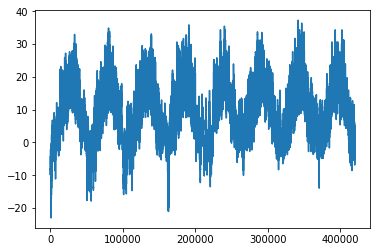

In [5]:
from matplotlib import pyplot as plt

temperature = float_data[:, 1]  # the first column is temperature
plt.plot(range(len(temperature)), temperature)
plt.show()

## First 10 days tempearture changes
Every 10 mins generates a data point. One day generates 6x24 = 144 data points

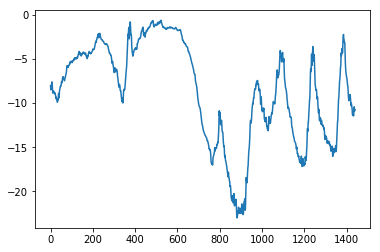

In [5]:
plt.plot(range(1440), temp[:1440])
plt.show()

## Normalize the input dataset

In [6]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std
print("Temperature Std: {}".format(std[0]))

Temperature Std: 8.480433884862078


In [7]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    
    # Calculate the start and end points of generated dataset
    if max_index is None:
        max_index = len(data) - delay - 1
    
    i = min_index + lookback
    
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index)) # choose batch_size data points
            i += len(rows) # update the start point
        
        # Initialize a sample array and a target array
        # Sample array is to store the past data points, while target array is for labels
        samples = np.zeros((
                            len(rows),
                            lookback // step, # calculate data points in the past period
                            data.shape[-1]
                            ))
        
        targets = np.zeros((len(rows),))
        
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

## Some parameter settings for data generation

lookback = 1440 = 144x10, Our observations will look back the past 10 days for learning.

steps = 6, We choose one data point per hour rather than every 10mins.

delay = 144, our targets/predictions will be 24 hours in the future.

batch_size = 128, every 128 sequences(past 10 days temperature + lables) in a batch to process


In [8]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000, # 20,000 samples for training
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)

val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000, # 1,000 samples for validation
                    step=step,
                    batch_size=batch_size)

test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001, # 1,200 samples for tests
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps = (300000 - 200001 - lookback) // batch_size

# This is how many steps to draw from `test_gen`
# in order to see the whole test set:
test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [10]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import Adam

/home/ubuntu/anaconda/envs/py36-venv/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [9]:

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])
                    )
         )
# No activation function for regression problem
model.add(layers.Dense(1))


# Regression problem without activation function
model.compile(optimizer=Adam(), loss='mae', metrics=['mae'])
history = model.fit_generator(train_gen,
                              steps_per_epoch=100,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps
                             )

/home/ubuntu/anaconda/envs/py36-venv/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Epoch 1/40
100/100 [==============================] - 88s 885ms/step - loss: 0.3917 - mean_absolute_error: 0.3917 - val_loss: 0.2878 - val_mean_absolute_error: 0.2878
Epoch 2/40
100/100 [==============================] - 85s 847ms/step - loss: 0.3357 - mean_absolute_error: 0.3357 - val_loss: 0.2819 - val_mean_absolute_error: 0.2819
Epoch 3/40
100/100 [==============================] - 85s 849ms/step - loss: 0.3306 - mean_absolute_error: 0.3306 - val_loss: 0.2825 - val_mean_absolute_error: 0.2825
Epoch 4/40
100/100 [==============================] - 84s 842ms/step - loss: 0.3265 - mean_absolute_error: 0.3265 - val_loss: 0.2803 - val_mean_absolute_error: 0.2803
Epoch 5/40
100/100 [==============================] - 84s 839ms/step - loss: 0.3227 - mean_absolute_error: 0.3227 - val_loss: 0.2837 - val_mean_absolute_error: 0.2837
Epoch 6/40
100/100 [==============================] - 84s 840ms/step - loss: 0.3165 - mean_absolute_error: 0.3165 - val_loss: 0.2762 - val_mean_absolute_error: 0.276

## Combining 1D Convnet and LSTM

In [11]:
model = Sequential()

model.add(layers.Conv1D(32, 5, activation='relu',
                        input_shape=(None, float_data.shape[-1]))
         )
model.add(layers.MaxPooling1D(3))

model.add(layers.Conv1D(32, 5, activation='relu'))

model.add(layers.LSTM(32, dropout=0.1, recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.summary()

model.compile(optimizer=Adam(), loss='mae')

history = model.fit_generator(train_gen,
                              steps_per_epoch=100,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, None, 32)          2272      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 15,777
Trainable params: 15,777
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
100/100 [==============================] - 43s 430ms/step - loss: 0.4211 - val_loss: 0.3365
Epoch 2/40
100/100 [===============

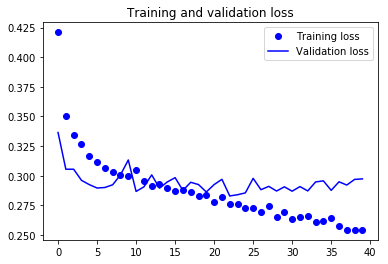

In [12]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()